In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

# Load datasets
orders = pd.read_csv('/content/drive/MyDrive/Affinity task 4/orders.csv')
c4_submission_form = pd.read_csv('/content/drive/MyDrive/Affinity task 4/c4_submission_form.csv')

# Preprocess orders dataset
orders['startdate'] = pd.to_datetime(orders['startdate'], format='%Y-%m-%d', errors='coerce')
orders['enddate'] = pd.to_datetime(orders['enddate'], format='%Y-%m-%d', errors='coerce')

# Create weekly periods starting on Sunday
orders['week_period'] = orders['startdate'].dt.to_period('W-SUN')
orders['week_start'] = orders['week_period'].dt.to_timestamp(how='start')

# Aggregate weekly data for incoming orders and in-flight campaigns by team
weekly_data = orders.groupby(['week_start', 'dim_team_key']).agg(
    incoming_orders=('dim_order_key', 'count'),
    in_flight_campaigns=('dim_order_key', lambda x: ((orders.loc[x.index, 'startdate'] <= orders.loc[x.index, 'week_period'].dt.end_time) & \
                                                  (orders.loc[x.index, 'enddate'] >= orders.loc[x.index, 'week_period'].dt.start_time)).sum())
).reset_index()

# Feature engineering
weekly_data['week_of_year'] = weekly_data['week_start'].dt.isocalendar().week
weekly_data['month'] = weekly_data['week_start'].dt.month
weekly_data['year'] = weekly_data['week_start'].dt.year

# Prepare the dataset for modeling
features = ['week_of_year', 'month', 'year', 'dim_team_key']
X = pd.get_dummies(weekly_data[features], columns=['dim_team_key'])
y_orders = weekly_data['incoming_orders']
y_campaigns = weekly_data['in_flight_campaigns']

# Train-test split
X_train_orders, X_test_orders, y_train_orders, y_test_orders = train_test_split(X, y_orders, test_size=0.2, random_state=42)
X_train_campaigns, X_test_campaigns, y_train_campaigns, y_test_campaigns = train_test_split(X, y_campaigns, test_size=0.2, random_state=42)

# Train XGBoost for incoming orders
xgb_orders = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_orders.fit(X_train_orders, y_train_orders)

# Train XGBoost for in-flight campaigns
xgb_campaigns = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_campaigns.fit(X_train_campaigns, y_train_campaigns)

# Evaluate models
orders_preds = xgb_orders.predict(X_test_orders)
campaigns_preds = xgb_campaigns.predict(X_test_campaigns)

print("MAE for Incoming Orders:", mean_absolute_error(y_test_orders, orders_preds))
print("MAE for In-Flight Campaigns:", mean_absolute_error(y_test_campaigns, campaigns_preds))

# Forecasting
forecast_features = c4_submission_form[['week_start', 'dim_team_key']].copy()
forecast_features['week_start'] = pd.to_datetime(forecast_features['week_start'], errors='coerce')
forecast_features['week_of_year'] = forecast_features['week_start'].dt.isocalendar().week
forecast_features['month'] = forecast_features['week_start'].dt.month
forecast_features['year'] = forecast_features['week_start'].dt.year
forecast_features = pd.get_dummies(forecast_features, columns=['dim_team_key'])

# Align columns with training data
forecast_features = forecast_features.reindex(columns=X.columns, fill_value=0)

# Predict and update submission form
c4_submission_form['incoming_orders'] = xgb_orders.predict(forecast_features)
c4_submission_form['in_flight_campaigns'] = xgb_campaigns.predict(forecast_features)

# Save updated submission form
c4_submission_form.to_csv('updated_c4_submission_formg.csv', index=False)


MAE for Incoming Orders: 18.594919532815986
MAE for In-Flight Campaigns: 18.379952350300606


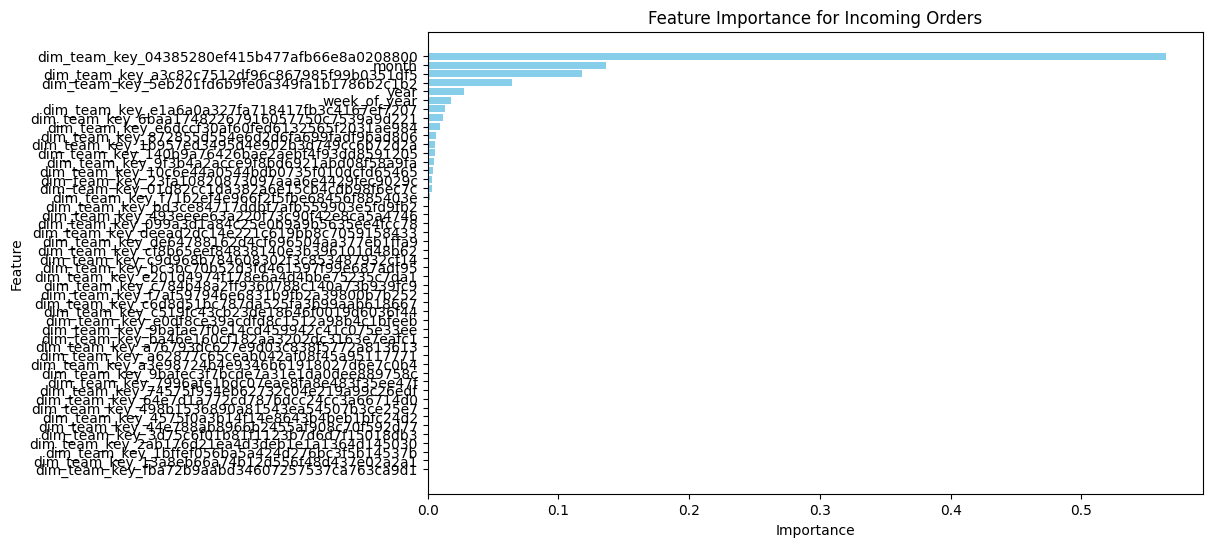

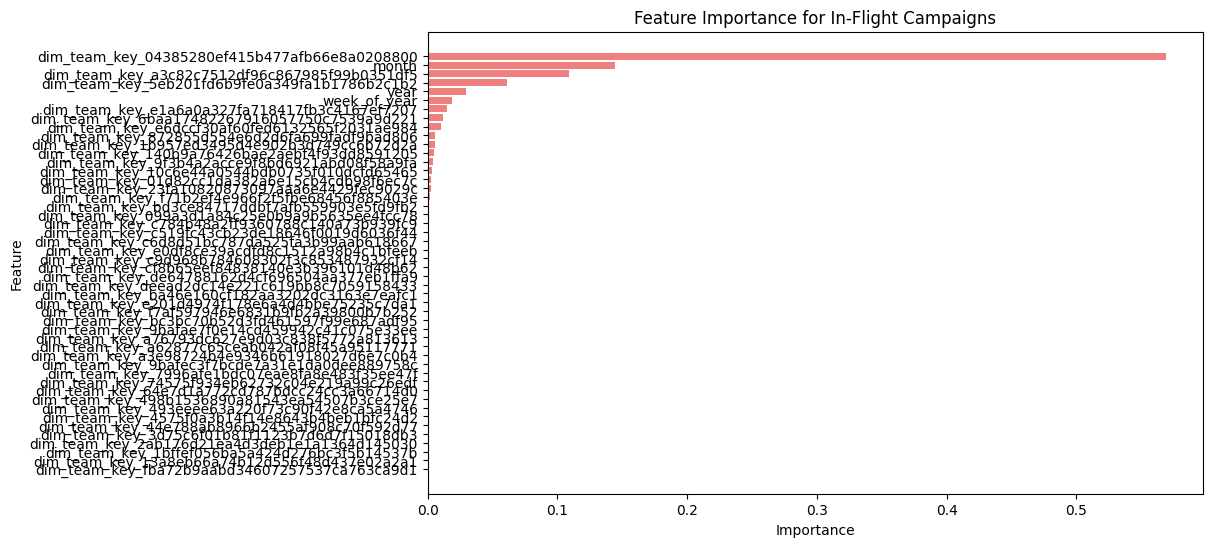

In [22]:
import matplotlib.pyplot as plt

# Feature importance for incoming orders model
orders_feature_importance = xgb_orders.feature_importances_
orders_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': orders_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for incoming orders
plt.figure(figsize=(10, 6))
plt.barh(orders_feature_importance_df['Feature'], orders_feature_importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Incoming Orders')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

# Feature importance for in-flight campaigns model
campaigns_feature_importance = xgb_campaigns.feature_importances_
campaigns_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': campaigns_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for in-flight campaigns
plt.figure(figsize=(10, 6))
plt.barh(campaigns_feature_importance_df['Feature'], campaigns_feature_importance_df['Importance'], color='lightcoral')
plt.title('Feature Importance for In-Flight Campaigns')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()
